# Import Libraries

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import os
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from psaw import PushshiftAPI
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

/Users/vishalduhan/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


# Data Scrape

## Create directory to store data

In [2]:
try:
    os.makedirs("./data/Real_News_Data")
except FileExistsError:
    # directory already exists
    print("exits")
    pass

try:
    os.makedirs("./data/Fake_News_Data")    
except FileExistsError:
    # directory already exists
    print("exits")
    pass

exits
exits


## Onion and Nottheonion data

Chose to scrape posts from r/TheOnion and r/nottheonion in order to create a fake news model that could accurately distinguish between fake news and absurd news. Which is a major concern in differentiating Real absurd news from clickbait. From each subbreddit I scraped the following information:

title: title of subreddit post

subreddit: which subreddit the post belongs to

author: author's username of a post

score: the score received on reddit

domain: the domain referenced in the post

num_comments: the number of comments for a post

created_utc: date and time the post was created

## REDDIT API SCRAPE FUNCTION

In [3]:
def scrape_data(subreddit,limit):
    
    # Instantiate 
    api = PushshiftAPI()

    # Create list of scraped data
    scrape_list = list(api.search_submissions(subreddit=subreddit,
                                filter=['title', 'subreddit', 'num_comments', 'author', 'subreddit_subscribers', 'score', 'domain', 'created_utc'],
                                limit=limit))

    #Filter list to only show Subreddit titles and Subreddit category 
    clean_scrape_lst = []
    for i in range(len(scrape_list)):
        scrape_dict = {}
        scrape_dict['subreddit'] = scrape_list[i][5]
        scrape_dict['author'] = scrape_list[i][0]
        scrape_dict['domain'] = scrape_list[i][2]
        scrape_dict['title'] = scrape_list[i][7]
        scrape_dict['num_comments'] = scrape_list[i][3]
        scrape_dict['score'] = scrape_list[i][4]
        scrape_dict['timestamp'] = scrape_list[i][1]
        clean_scrape_lst.append(scrape_dict)

    # Show number of subscribers
    print(subreddit, 'subscribers:',scrape_list[1][6])
    
    # Return list of scraped data
    return clean_scrape_lst

## SCRAPE r/nottheonion

In [4]:
df_not_onion = pd.DataFrame(scrape_data('nottheonion',7000))

nottheonion subscribers: 17075984


In [5]:
df_not_onion

,subreddit,author,domain,title,num_comments,score,timestamp
0,nottheonion,DaFunkJunkie,businessinsider.com,"Trump says that 'if we stop testing right now,...",1,1,1592254366
1,nottheonion,user98710,rte.ie,Garden ornaments found to be WWII artillery ro...,0,1,1592254247
2,nottheonion,therealchappy24,thehill.com,Trump on coronavirus: 'If we stop testing righ...,0,1,1592254237
3,nottheonion,TheKekStreetJoural,edinburghlive.co.uk,Edinburgh Zoo in row with Scots gangster over ...,0,1,1592254233
4,nottheonion,[deleted],businessinsider.com.au,"Trump says that 'if we stop testing right now,...",1,1,1592254225
...,...,...,...,...,...,...,...
6995,nottheonion,tenders74,businessinsider.com,Mitch McConnell is pushing the Senate to pass ...,2,1,1589418533
6996,nottheonion,D-D-Dakota,nypost.com,"Kim Jong Un may be holed up with his 2,000-wom...",2,1,1589418321
6997,nottheonion,my_ship_has_sunk,thehill.com,"Firefighting goats escape, wreak 'havoc' on Ca...",2,1,1589418267
6998,nottheonion,Russkiboi,israel21c.org,"Fearing end of the world, man returns ancient ...",10,1,1589417852


In [6]:
df_not_onion.to_csv('./data/Real_News_Data/not_onion.csv')

## SCRAPE r/theonion

In [7]:
df_onion = pd.DataFrame(scrape_data('theonion',6000))

theonion subscribers: 149033


In [8]:
df_onion

,subreddit,author,domain,title,num_comments,score,timestamp
0,TheOnion,bwint1,local.theonion.com,City Enters Phase 4 Of Pretending Coronavirus ...,3,4,1592239238
1,TheOnion,hiddeninsite01,theonion.com,Online Activists Raise $5 Million To Create Ne...,3,1,1592227831
2,TheOnion,hiddeninsite98,theonion.com,ExxonMobil Simplifies Oil Extraction By Cuttin...,17,1,1592227780
3,TheOnion,baynen,youtu.be,Stop and kiss by police,1,2,1592201519
4,TheOnion,MagicApe,i.redd.it,International Con Man Barack Obama Leaves U.S....,1,1,1592190587
...,...,...,...,...,...,...,...
5995,TheOnion,aresef,politics.theonion.com,White House Corrects Transcript To Add Few Mor...,0,1,1538507685
5996,TheOnion,GriffonsChainsaw,theonion.com,"Cure For Cancer Only 10 Years Away, Announce S...",0,1,1538506912
5997,TheOnion,GriffonsChainsaw,local.theonion.com,Area Man Always Carbo-Loading Just In Case,0,1,1538506911
5998,TheOnion,GriffonsChainsaw,theonion.com,Coca-Cola May Move Into Marijuana Products,0,1,1538506911


In [9]:
df_onion.to_csv('./data/Fake_News_Data/onion.csv')

# Web Scraping: The Guardian

In [10]:
urls = ["https://www.theguardian.com/us","https://www.theguardian.com/us-news/us-elections-2020",
       "https://www.theguardian.com/us/sport","https://www.theguardian.com/us/culture",
       "https://www.theguardian.com/us-news/us-politics"
       ,"https://www.theguardian.com/us/environment","https://www.theguardian.com/us/business"
       ,"https://www.theguardian.com/science","https://www.theguardian.com/us/technology","https://www.theguardian.com/world"]

extract_Guardian_news scraps the page based on url, then search for class that contains news link in them and appends those link in a list.

In [11]:
def extarct_Guardian_news(url):
    # Request
    r1 = requests.get(url)
    r1.status_code

    # We'll save in coverpage the cover page content
    coverpage = r1.content

    # Soup creation
    soup1 = BeautifulSoup(coverpage, 'html5lib')

    # News identification
    coverpage_news = soup1.find_all('h3', class_='fc-item__title')
    number_of_articles = len(coverpage_news)
    
    

    for n in np.arange(0, number_of_articles):

        # We need to ignore "live" pages since they are not articles
        if "live" in coverpage_news[n].find('a')['href']:  
            continue

        # Getting the link of the article
        link = coverpage_news[n].find('a')['href']
        list_links.append(link)

        # Getting the title
        title = coverpage_news[n].find('a').get_text()
        list_titles.append(title)
    

In [12]:
list_links = []
list_titles = []
for link in urls:
    for i in range(1,50):
        new_link=link+"?page="+str(i)
        extarct_Guardian_news(link)

In [13]:
df_show_info = pd.DataFrame(
    {'Article Title': list_titles,
     'Article Link': list_links})
df_show_info["Fake"]=0
df_show_info.to_csv('./data/Real_News_Data/TheGuardiandata.csv')

# Web Scraping: Dailymail

In [14]:
urls = ["https://www.dailymail.co.uk/ushome/index.html"]

extract_Daily_Mail_news scraps the page based on url, then search for class that contains news link in them and appends those link in a list.

In [15]:
list_links = []
list_titles = []
def extarct_Daily_Mail_news(url):
    # Request
    r1 = requests.get(url)
    r1.status_code

    # We'll save in coverpage the cover page content
    coverpage = r1.content

    # Soup creation
    soup1 = BeautifulSoup(coverpage, 'html5lib')

    # News identification
    coverpage_news = soup1.find_all('h2', class_='linkro-darkred')

    number_of_articles = len(coverpage_news)
    
    

    for n in np.arange(0, number_of_articles):
         # Getting the link of the article
        link = url + coverpage_news[n].find('a')['href']
        list_links.append(link)

        # Getting the title
        title = coverpage_news[n].find('a').get_text()
        list_titles.append(title)    

In [16]:
for link in urls:
    for i in range(1,70):
        new_link=link+"?page="+str(i)
        extarct_Daily_Mail_news(link)

In [17]:
df_show_info = pd.DataFrame(
    {'Article Title': list_titles,
     'Article Link': list_links})
df_show_info["Fake"]=0
df_show_info.to_csv('./data/Real_News_Data/DailyMail.csv')

# Import DATA

In [18]:
df_not_onion = pd.read_csv('./data/Real_News_Data/not_onion.csv')
df_guardian=pd.read_csv('./data/Real_News_Data/TheGuardiandata.csv')
df_daily_mail=pd.read_csv('./data/Real_News_Data/DailyMail.csv')

In [19]:
# Show first 5 rows of df_not_onion
print("Shape:", df_not_onion.shape)
df_not_onion["Fake"]=0
df_not_onion.head()

Shape: (7000, 8)


,Unnamed: 0,subreddit,author,domain,title,num_comments,score,timestamp,Fake
0,0,nottheonion,DaFunkJunkie,businessinsider.com,"Trump says that 'if we stop testing right now,...",1,1,1592254366,0
1,1,nottheonion,user98710,rte.ie,Garden ornaments found to be WWII artillery ro...,0,1,1592254247,0
2,2,nottheonion,therealchappy24,thehill.com,Trump on coronavirus: 'If we stop testing righ...,0,1,1592254237,0
3,3,nottheonion,TheKekStreetJoural,edinburghlive.co.uk,Edinburgh Zoo in row with Scots gangster over ...,0,1,1592254233,0
4,4,nottheonion,[deleted],businessinsider.com.au,"Trump says that 'if we stop testing right now,...",1,1,1592254225,0


In [20]:
# Show first 5 rows of df_guardian
df_guardian.rename(columns={"Article Title":"title"},inplace=True)
print("Shape:", df_guardian.shape)
df_guardian.head()

Shape: (24892, 4)


,Unnamed: 0,title,Article Link,Fake
0,0,Black trans people Tens of thousands across U...,https://www.theguardian.com/us-news/2020/jun/1...,0
1,1,Black trans people Tens of thousands across U...,https://www.theguardian.com/us-news/2020/jun/1...,0
2,2,Seattle Outrage at video showing child who wa...,https://www.theguardian.com/us-news/2020/jun/1...,0
3,3,Seattle Outrage at video showing child who wa...,https://www.theguardian.com/us-news/2020/jun/1...,0
4,4,Dominican Republic George Floyd protests spar...,https://www.theguardian.com/world/2020/jun/15/...,0


In [21]:
# Show first 5 rows of df_daily_mail
df_daily_mail.rename(columns={"Article Title":"title"},inplace=True)
print("Shape:", df_daily_mail.shape)
df_daily_mail.head()

Shape: (8550, 4)


,Unnamed: 0,title,Article Link,Fake
0,0,'Do I want to deal with this dude right now?' ...,https://www.dailymail.co.uk/ushome/index.html/...,0
1,1,San Francisco Karen's boyfriend is FIRED by in...,https://www.dailymail.co.uk/ushome/index.html/...,0
2,2,Trump will unveil police reform plan on Tuesda...,https://www.dailymail.co.uk/ushome/index.html/...,0
3,3,John Bolton will break his silence on Donald T...,https://www.dailymail.co.uk/ushome/index.html/...,0
4,4,FDA REVOKES emergency approval for hydroxychlo...,https://www.dailymail.co.uk/ushome/index.html/...,0


In [22]:
pd.set_option('display.max_colwidth', -1)

df_onion = pd.read_csv('./data/Fake_News_Data/onion.csv')
df_gossipcop_fake = pd.read_csv('./data/Fake_News_Data/gossipcop_fake.csv')
df_politifact_fake = pd.read_csv('./data/Fake_News_Data/politifact_fake.csv')

/Users/vishalduhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [23]:
# Show first 5 rows of df_onion
print("Shape:", df_onion.shape)
df_onion["Fake"]=1
df_onion.head()

Shape: (6000, 8)


,Unnamed: 0,subreddit,author,domain,title,num_comments,score,timestamp,Fake
0,0,TheOnion,bwint1,local.theonion.com,City Enters Phase 4 Of Pretending Coronavirus Over,3,4,1592239238,1
1,1,TheOnion,hiddeninsite01,theonion.com,Online Activists Raise $5 Million To Create New Martin Luther King Jr. Quote,3,1,1592227831,1
2,2,TheOnion,hiddeninsite98,theonion.com,ExxonMobil Simplifies Oil Extraction By Cutting Earth In Half,17,1,1592227780,1
3,3,TheOnion,baynen,youtu.be,Stop and kiss by police,1,2,1592201519,1
4,4,TheOnion,MagicApe,i.redd.it,International Con Man Barack Obama Leaves U.S. With $85 Million In Campaign Fundraising (2008),1,1,1592190587,1


In [24]:
# Show first 5 rows of df_gossipcop_fake
df_gossipcop_fake.rename(columns={"Article Title":"title",},inplace=True)
print("Shape:", df_gossipcop_fake.shape)
df_gossipcop_fake["Fake"]=1
df_gossipcop_fake.head()

Shape: (5323, 4)


,id,news_url,title,tweet_ids,Fake
0,gossipcop-2493749932,www.dailymail.co.uk/tvshowbiz/article-5874213/Did-Miley-Cyrus-Liam-Hemsworth-secretly-married.html,Did Miley Cyrus and Liam Hemsworth secretly get married?,284329075902926848\t284332744559968256\t284335412590297089\t284359918792880128\t284385385151332353\t284456388833452032\t284644878267318273\t284656558963564545\t284705391965794304\t284705391957401601\t284762425553723392\t284766089827721217\t284769766806257664\t284769769490620416\t284769775442337792\t284769772980301824\t284769778655186944\t284769777073917952\t284771913753042944\t284902943201837056\t284918939975303169\t285592266716884993\t285635421872979969\t285635516924301313\t285731324101287937\t295954533555793920\t296639632710459392\t296651276626825216\t700137152143699968\t700501642412560384\t700599457767890944\t700925213031141376\t757598980373045248\t757614017808437248\t757810204448743425\t757855454886293504\t818454872299163649\t818532208990371841\t818622382524997632\t818623644737871872\t824328059335692290\t840237926642536449\t840277988067430400\t840305556736872448\t840312641042104320\t840320383437877248\t840321378150670336\t840325449389600768\t840346792671698945\t840359115754999810\t840359140119699457\t840366459675062274\t840396881586982912\t840413370650050560\t840440847527116800\t840444299732910080\t840462550135365633\t841849268646338560\t849678041055887360\t925851191560556544\t927426728653230080\t927531012212457473\t927588875576528897\t927588875551363072\t927589121190760449\t927606510406029314\t928442019529162752\t928532613056352256\t928653424752758784\t953201937574342658\t953336408650993664\t953692192064884737\t953999445384888321\t954307670344916992\t1010039778891452416\t1010184150970654720\t1010184410115727361\t1010191444617752576\t1010229013908992000\t1010262428670709766\t1010334767701561344\t1010393809144799232\t1010418444016259072\t1011127764261396481\t1013723578834014208\t1013723601571340291\t1013723813685669889\t1016000562893123584\t1016431705132093440\t1036444296348663808\t1060594707447853058\t1060595446488358912\t1060679502240436224\t1060683397649952770\t1060708573590773761\t1060722227237318656\t1060812126200258560,1
1,gossipcop-4580247171,hollywoodlife.com/2018/05/05/paris-jackson-cara-delevingne-matching-outfits-night-out-nyc-dating-pic/,Paris Jackson & Cara Delevingne Enjoy Night Out In Matching Outfits: They Have ‘Amazing Chemistry’,992895508267130880\t992897935418503169\t992899529329569792\t992904299674923009\t992906330590597120\t992916937536516097\t992923845446328320\t992992387315060737\t993002463761453056\t993030134004248577\t993060047700676609\t993090513770180615\t993105619602227203\t993133763071651840\t993134760506675200,1
2,gossipcop-941805037,variety.com/2017/biz/news/tax-march-donald-trump-protest-1202031487/,Celebrities Join Tax March in Protest of Donald Trump,853359353532829696\t853359576543920128\t853359758400729088\t853360019814973440\t853360073564868608\t853360086479101952\t853360092174966784\t853360091411562496\t853360111670054913\t853360110843813888\t853360113872130048\t853360128501862400\t853360131999793152\t853360195149418496\t853360323981701120\t853360366302220288\t853360619352883200\t853360803646496769\t853361601281445890\t853362860830928897\t853363803848880128\t853364005624324098\t853366133638012929\t853366622190436352\t853367360777986048\t853367524565688320\t853367882004275200\t853368967108448257\t853369009592512516\t853369363038064640\t853369449457606657\t853369574552723456\t853369732589924352\t853370675913826304\t853371449351872512\t853371487360765952\t853371710820823040\t853371722292240384\t853371734732537856\t853372207912931328\t853372329669283840\t853372910211223552\t853373896937971712\t853375270555799552\t853375443751325696\t853375458766974976\t853378059067510784\t853380105376329733\t853383424068988928\t853383430758969344\t853388476410200064\t853388528474087424\t853394168613191680\t853396186157391872\t853399274939219968\t853406473489141761\t853462336371392513\t8534675075119

In [25]:
# Show first 5 rows of df_politifact_fake
df_politifact_fake.rename(columns={"Article Title":"title"},inplace=True)
print("Shape:", df_politifact_fake.shape)
df_politifact_fake["Fake"]=1
df_politifact_fake.head()

Shape: (432, 4)


id  \
0  politifact15014   
1  politifact15156   
2  politifact14745   
3  politifact14355   
4  politifact15371   

                                                                                                                        news_url  \
0  speedtalk.com/forum/viewtopic.php?t=51650                                                                                       
1  politics2020.info/index.php/2018/03/13/court-orders-obama-to-pay-400-million-in-restitution/                                    
2  www.nscdscamps.org/blog/category/parenting/467344/update-second-roy-moore-accuser-works-for-michelle-obama-right-now-departed   
3  https://howafrica.com/oscar-pistorius-attempts-commit-suicide/                                                                  
4  http://washingtonsources.org/trump-votes-for-death-penalty-for-being-gay-5/                                                     

                                                                   title  \
0  BREAKING: First NFL Team Declares Bankruptcy Over Kneeling Thugs        
1  Court Orders Obama To Pay $400 Million In Restitution                   
2  UPDATE: Second Roy Moore Accuser Works For Michelle Obama Right NOW -   
3  Oscar Pistorius Attempts To Commit Suicide                              
4  Trump Votes For Death Penalty For Being Gay                             

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

## Data Cleaning function

In [26]:
def clean_data(dataframe):

    # Drop duplicate rows
    dataframe.drop_duplicates(subset='title', inplace=True)
    
    # Remove punctation
    dataframe['title'] = dataframe['title'].str.replace('[^\w\s]',' ')

    # Remove numbers 
    dataframe['title'] = dataframe['title'].str.replace('[^A-Za-z]',' ')

    # Make sure any double-spaces are single 
    dataframe['title'] = dataframe['title'].str.replace('  ',' ')
    dataframe['title'] = dataframe['title'].str.replace('  ',' ')

    # Transform all text to lowercase
    dataframe['title'] = dataframe['title'].str.lower()
    
    print("New shape:", dataframe.shape)
    return dataframe.head()

## Plotting function

In [27]:
def bar_plot(x, y, title, color):    
    
    # Set up barplot 
    plt.figure(figsize=(9,6))
    g=sns.barplot(x, y,color = color)    
    ax=g

    # Label the graph
    plt.title(title, fontsize = 15)
    plt.xticks(fontsize = 10)

    
    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for p in ax.patches:
        totals.append(p.get_width())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    for p in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(p.get_width()+.3, p.get_y()+.38, \
                int(p.get_width()), fontsize=10)

# Cleaning Data

### Clean df_not_onion

In [28]:
clean_data(df_not_onion)["title"]

New shape: (5270, 9)


0    trump says that if we stop testing right now we d have very few cases of coronavirus
1    garden ornaments found to be wwii artillery rounds                                  
2    trump on coronavirus if we stop testing right now we d have very few cases if any   
3    edinburgh zoo in row with scots gangster over the sale of giant gorilla heads       
5    other voices                                                                        
Name: title, dtype: object

### Clean df_guardian

In [29]:
clean_data(df_guardian)["title"]

New shape: (432, 4)


0    black trans people tens of thousands across us march in support                      
2    seattle outrage at video showing child who was maced by police at protest            
4    dominican republic george floyd protests spark reckoning with race as elections loom 
6    us supreme court court rules employers cannot discriminate against lgbtq workers     
7    tulsa president claims m want tickets for rally opposed by top health official       
Name: title, dtype: object

### Clean df_daily_mail

In [30]:
clean_data(df_daily_mail)["title"]

New shape: (124, 4)


0     do i want to deal with this dude right now police officer first to arrive at the atlanta wendy s where intoxicated rayshard brooks was found came close to letting the incident slide bodycam footage shows
1    san francisco karen s boyfriend is fired by investment bank for accusing filipino resident of vandalism because he was painting a black lives matter slogan on his own property                             
2    trump will unveil police reform plan on tuesday that will say there is systemic racism and will meet black families who have suffered at hands of cops                                                      
3    john bolton will break his silence on donald trump in primetime special interview on blockbuster book as the white house moves to block it days before publication                                          
4    fda revokes emergency approval for hydroxychloroquine to treat coronavirus after the malaria drug touted by trump failed to help patients in a chinese clin

### Clean df_onion

In [31]:
clean_data(df_onion)["title"]

New shape: (5483, 9)


0    city enters phase of pretending coronavirus over                                     
1    online activists raise million to create new martin luther king jr quote             
2    exxonmobil simplifies oil extraction by cutting earth in half                        
3    stop and kiss by police                                                              
4    international con man barack obama leaves u s with  million in campaign fundraising  
Name: title, dtype: object

### Clean df_gossipcop_fake

In [32]:
clean_data(df_gossipcop_fake)["title"]

New shape: (4896, 5)


0    did miley cyrus and liam hemsworth secretly get married                                       
1    paris jackson cara delevingne enjoy night out in matching outfits they have amazing chemistry 
2    celebrities join tax march in protest of donald trump                                         
3    cindy crawford s daughter kaia gerber wears a wig after dining with harry styles              
4    full list of  oscar nominations variety                                                       
Name: title, dtype: object

### Clean df_politifact_fake

In [33]:
clean_data(df_politifact_fake)["title"]

New shape: (428, 5)


0    breaking first nfl team declares bankruptcy over kneeling thugs    
1    court orders obama to pay  million in restitution                  
2    update second roy moore accuser works for michelle obama right now 
3    oscar pistorius attempts to commit suicide                         
4    trump votes for death penalty for being gay                        
Name: title, dtype: object

In [34]:
df_onion.isnull().sum()


Unnamed: 0      0
subreddit       0
author          0
domain          0
title           0
num_comments    0
score           0
timestamp       0
Fake            0
dtype: int64

In [35]:
df_not_onion.isnull().sum()

Unnamed: 0      0
subreddit       0
author          0
domain          0
title           0
num_comments    0
score           0
timestamp       0
Fake            0
dtype: int64

# Exploratory Data Analysis (EDA)

### r/TheOnion: Most Active Authors

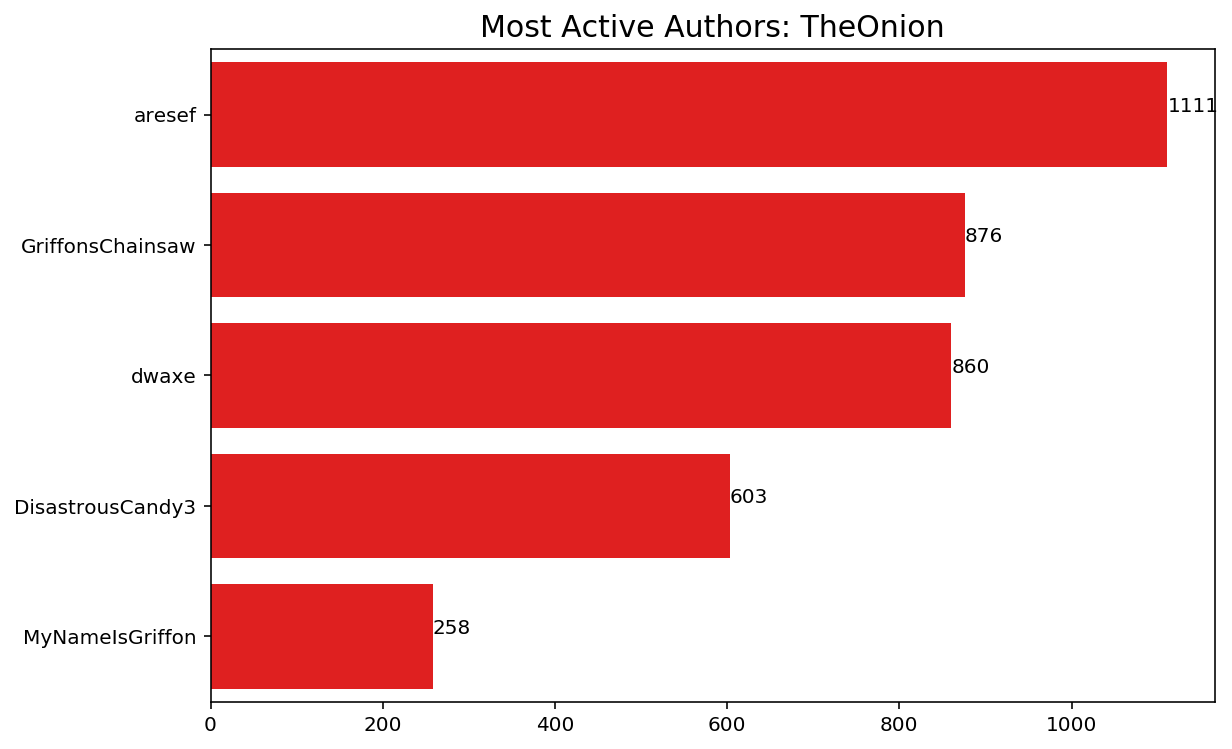

In [36]:
# Set x values: # of posts 
df_onion_authors = df_onion['author'].value_counts() 
df_onion_authors = df_onion_authors[df_onion_authors > 100].sort_values(ascending=False)

# Set y values: Authors 
df_onion_authors_index = list(df_onion_authors.index)

# Call function
bar_plot(df_onion_authors.values[0:5], df_onion_authors_index[0:5], 'Most Active Authors: TheOnion', 'red') 

### r/nottheonion: Most Active Authors

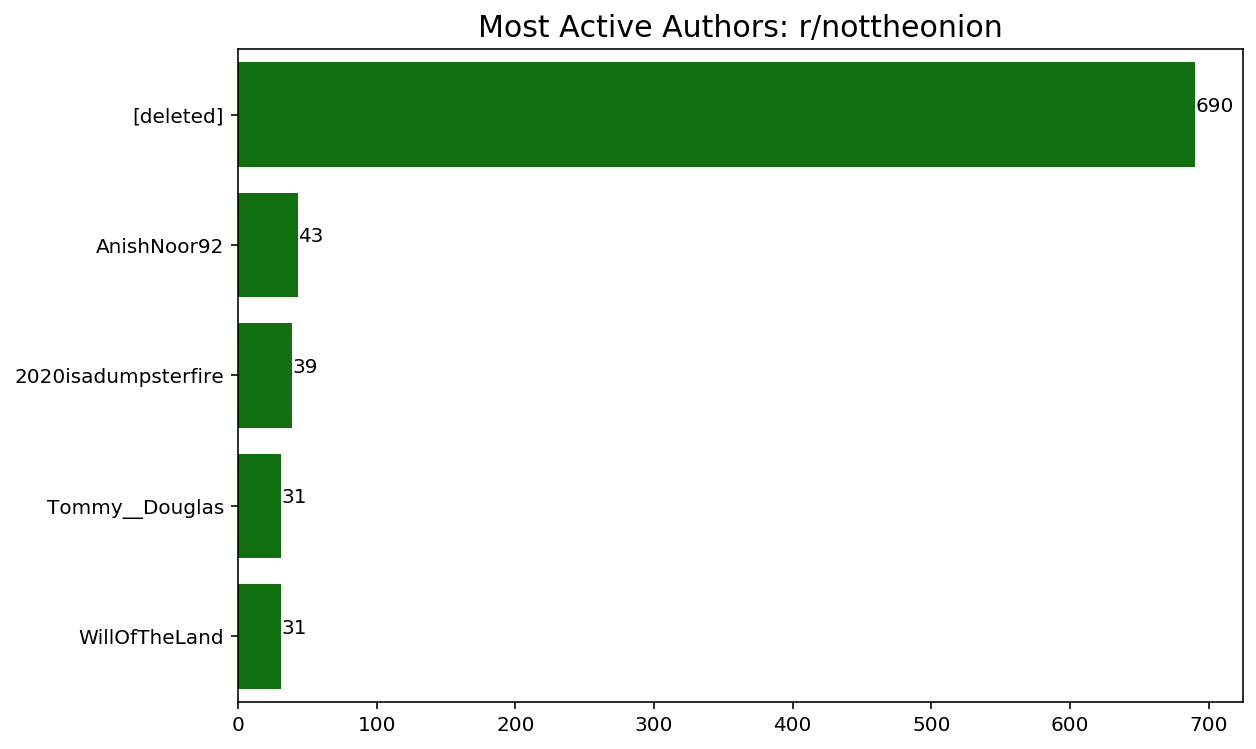

In [37]:
# Set x values: # of posts
df_not_onion_authors = df_not_onion['author'].value_counts() 
df_not_onion_authors = df_not_onion_authors[df_not_onion_authors > 20].sort_values(ascending=False)

# Set y values: Authors
df_not_onion_authors_index = list(df_not_onion_authors.index)

# Call function
bar_plot(df_not_onion_authors.values[0:5], df_not_onion_authors_index[0:5], 'Most Active Authors: r/nottheonion','g') 

### r/TheOnion: Most Referenced Domains

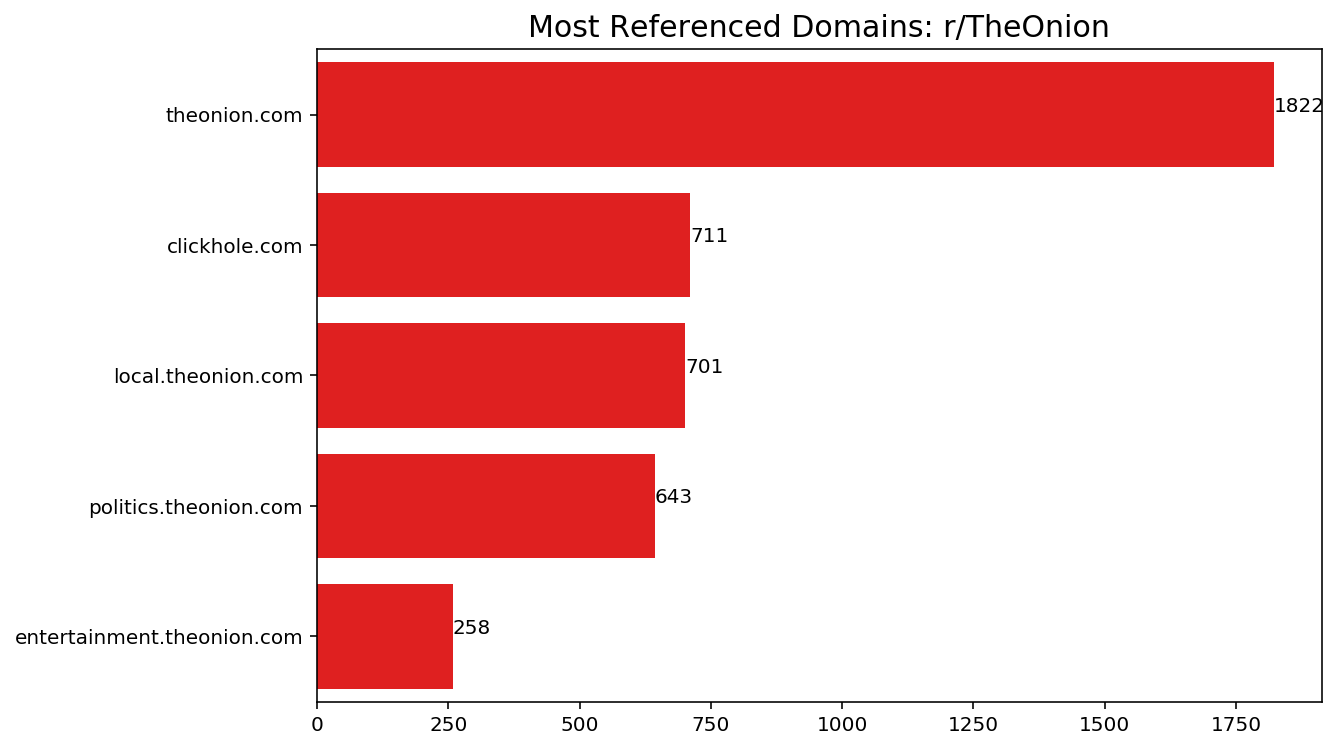

In [38]:
# Set x values: # of posts
df_onion_domain = df_onion['domain'].value_counts() 
df_onion_domain = df_onion_domain.sort_values(ascending=False).head(5)

# Set y values: Domains 
df_onion_domain_index = list(df_onion_domain.index)

# Call function
bar_plot(df_onion_domain.values, df_onion_domain_index, 'Most Referenced Domains: r/TheOnion','r') 

### r/nottheonion: Most Referenced Domains

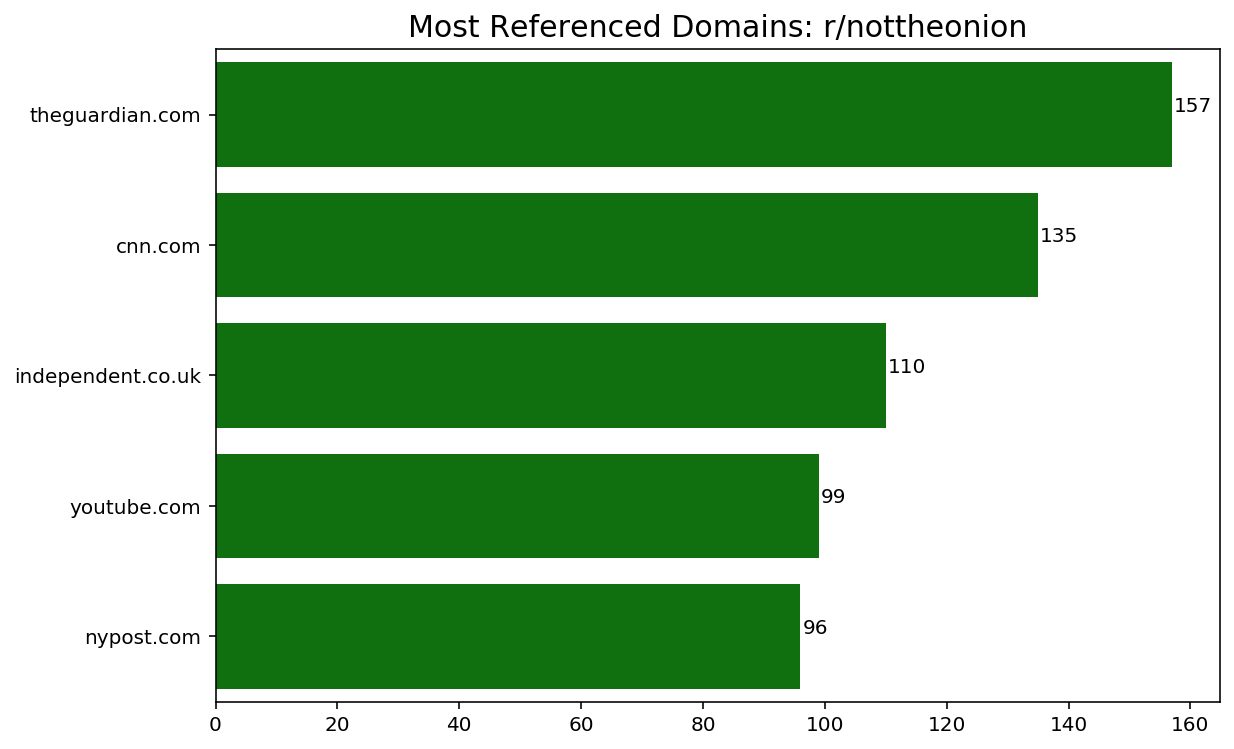

In [39]:
# Set x values: # of posts greater than 100
df_nonion_domain = df_not_onion['domain'].value_counts() 
df_nonion_domain = df_nonion_domain.sort_values(ascending=False).head(5)

# Set y values: Names of authors 
df_nonion_domain_index = list(df_nonion_domain.index)

# Call function
bar_plot(df_nonion_domain.values, df_nonion_domain_index, 'Most Referenced Domains: r/nottheonion','g') 

It can be seen that even in Onion and NottheOnion, real news have reliable domains while fake news have unreliable Domains.

# NLP

### Concatenate DataFrames

In [40]:
# Combining data with only 'Fake' (target) and 'title' (predictor) columns
df = pd.concat([df_onion[['Fake', 'title']], df_gossipcop_fake[['Fake', 'title']], df_politifact_fake[['Fake', 'title']], 
                df_not_onion[['Fake', 'title']],df_guardian[['Fake', 'title']],df_daily_mail[['Fake', 'title']]], axis=0)

#Reset the index
df = df.reset_index(drop=True)
df.head(10)

,Fake,title
0,1,city enters phase of pretending coronavirus over
1,1,online activists raise million to create new martin luther king jr quote
2,1,exxonmobil simplifies oil extraction by cutting earth in half
3,1,stop and kiss by police
4,1,international con man barack obama leaves u s with million in campaign fundraising
5,1,judge rules white girl will be tried as black adult
6,1,man not sure why he thought most psychologically taxing situation of his life would be the thing to make him productive
7,1,they were ahead of their time
8,1,tampa bay gay prostitutes gearing up for flood of closeted republicans
9,1,red sox ask fans to switch from racial to homophobic slurs when taunting opposing players


In [41]:
df.shape

(16633, 2)

### FAKE:1     REAL:0


# CountVectorizer()

### Count Vectorize `df` where `Fake` is `1`
 - `ngram_range = (1,1)`

In [42]:
# Set variables to show Thefake Titles
mask_on = df['Fake'] == 1
df_Fake_News_titles = df[mask_on]['title']
print(df_Fake_News_titles.shape)
# Instantiate a CountVectorizer
cv1 = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
Fake_cvec = cv1.fit_transform(df_Fake_News_titles)

# Convert Fake_cvec into a DataFrame
Fake_cvec_df = pd.DataFrame(Fake_cvec.toarray(),
                   columns=cv1.get_feature_names())

# Inspect head of fake Titles cvec
print(Fake_cvec_df.shape)
# print(Fake_cvec_df)

(10807,)
(10807, 15258)


### Count Vectorize `df` where `Fake` is `0`
 - `ngram_range = (1,1)`

In [43]:
# Set variables to show Real News Titles
mask_no = df['Fake'] == 0
df_real_news_titles = df[mask_no]['title']
print(df_real_news_titles.shape)
# Instantiate a CountVectorizer
cv2 = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
real_cvec = cv2.fit_transform(df_real_news_titles)

# Convert onion_cvec into a DataFrame
real_cvec_df = pd.DataFrame(real_cvec.toarray(),
                   columns=cv2.get_feature_names())

# Inspect head of Real News Titles cvec
print(real_cvec_df.shape)

(5826,)
(5826, 9968)


### Fake News: Top 10 Unigrams 

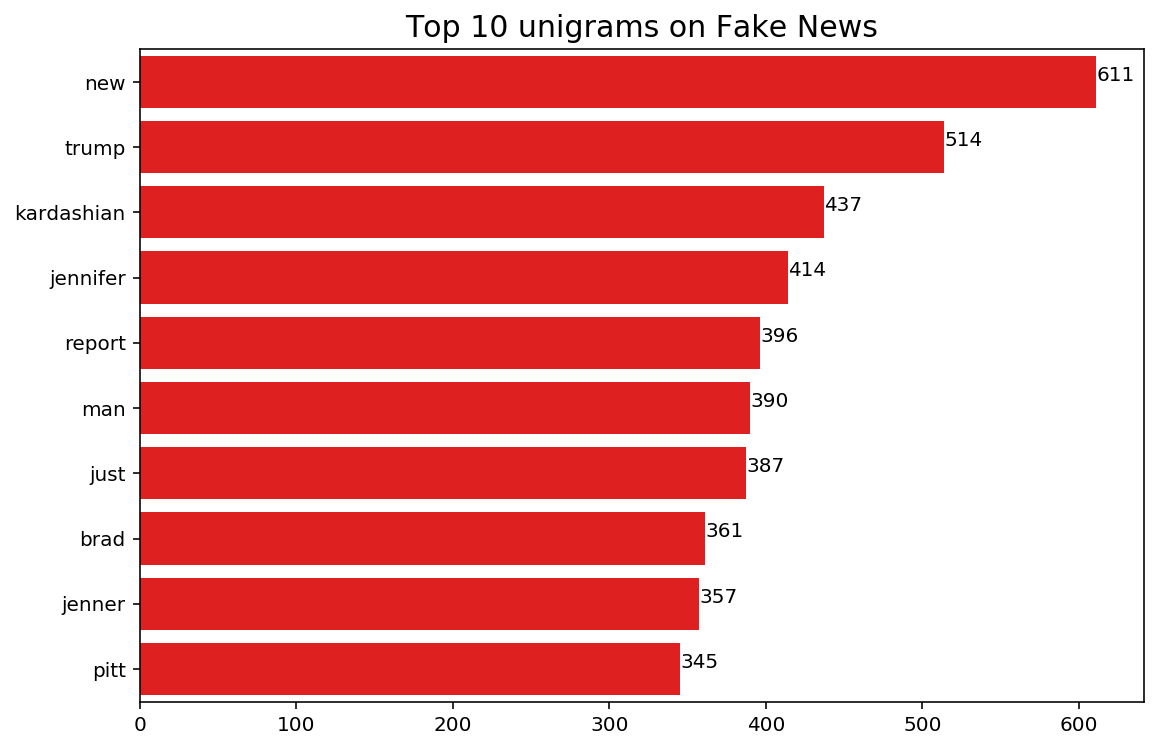

In [44]:
# Set up variables to contain top 5 most used words in Onion
Fake_wc = Fake_cvec_df.sum(axis = 0)
Fake_top_10 = Fake_wc.sort_values(ascending=False).head(10)

# Call function
bar_plot(Fake_top_10.values, Fake_top_10.index, 'Top 10 unigrams on Fake News','r') 

### Real News: Top 10 Unigrams

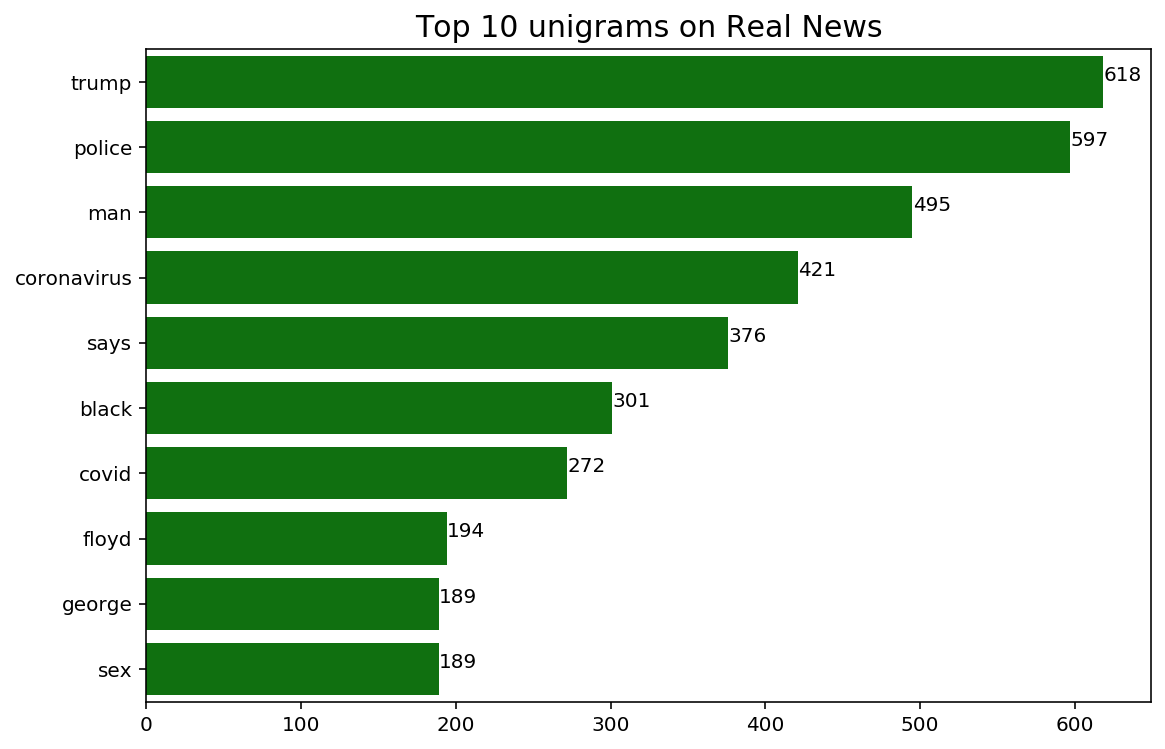

In [45]:
# Set up variables to contain top 5 most used words in Onion
real_wc = real_cvec_df.sum(axis = 0)
real_top_10 = real_wc.sort_values(ascending=False).head(10)

# Call function
bar_plot(real_top_10.values, real_top_10.index, 'Top 10 unigrams on Real News','g') 

create set of common words between real and fake

In [46]:
# Create list of unique words in top five
real_10_set = set(real_top_10.index)
fake_10_set = set(Fake_top_10.index)

# Return common words
common_unigrams = fake_10_set.intersection(real_10_set)
common_unigrams

{'man', 'trump'}

### Count Vectorize `df` where `Fake` is `1`
 - `ngram_range = (2,2)`

In [47]:
# Set variables to show fake Titles
mask = df['Fake'] == 1
df_Fake_titles = df[mask]['title']

# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english', ngram_range=(2,2))

# Fit and transform the vectorizer on our corpus
fake_cvec = cv.fit_transform(df_Fake_titles)

# Convert fake_cvec into a DataFrame
fake_cvec_df = pd.DataFrame(fake_cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect head of fake Titles cvec
print(fake_cvec_df.shape)

(10807, 60815)


### Count Vectorize `df` where `Fake` is `0`
 - `ngram_range = (2,2)`

In [48]:
# Set variables to show real Titles
mask = df['Fake'] == 0
df_real_titles = df[mask]['title']

# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english', ngram_range=(2,2))

# Fit and transform the vectorizer on our corpus
real_cvec = cv.fit_transform(df_real_titles)

# Convert onion_cvec into a DataFrame
real_cvec_df = pd.DataFrame(real_cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect head of real Titles cvec
print(real_cvec_df.shape)

(5826, 31440)


### Fake: Top 10 Bigrams

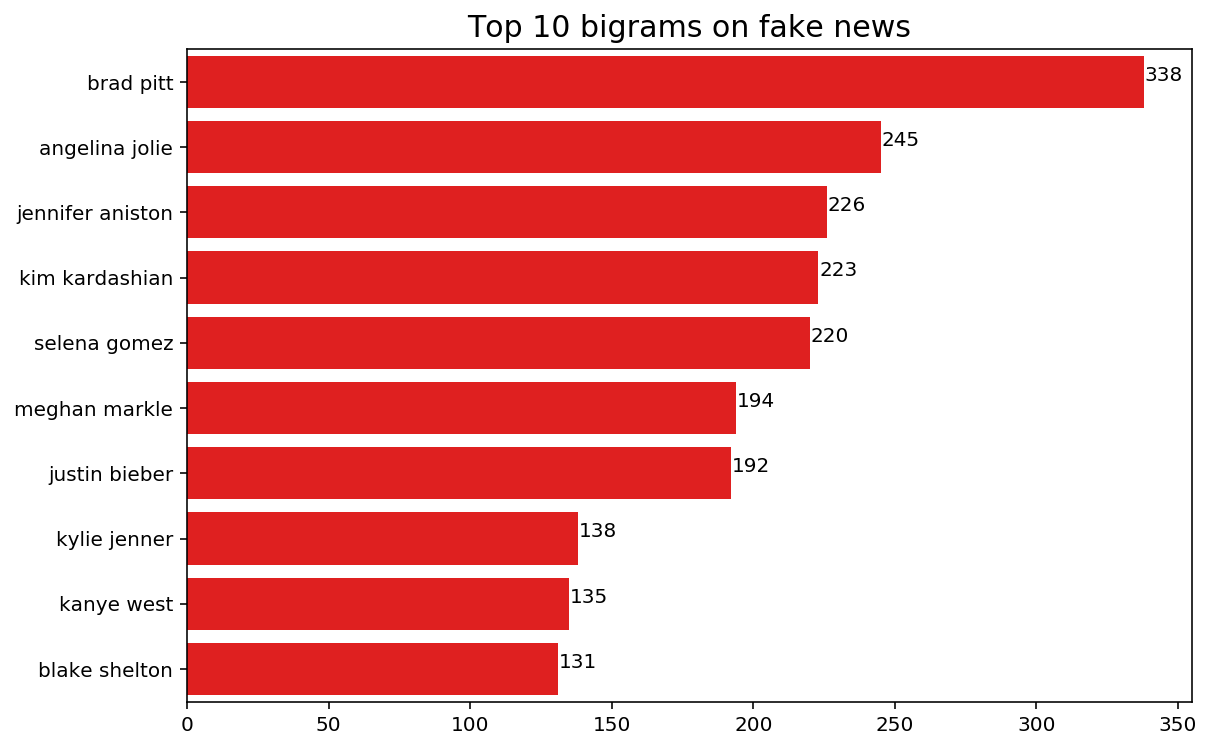

In [49]:
# Set up variables to contain top 10 most used bigrams 
fake_wc = fake_cvec_df.sum(axis = 0)
fake_top_10 = fake_wc.sort_values(ascending=False).head(10)

# Call function
bar_plot(fake_top_10.values, fake_top_10.index, 'Top 10 bigrams on fake news','r') 

### Real: Top 10 Bigrams

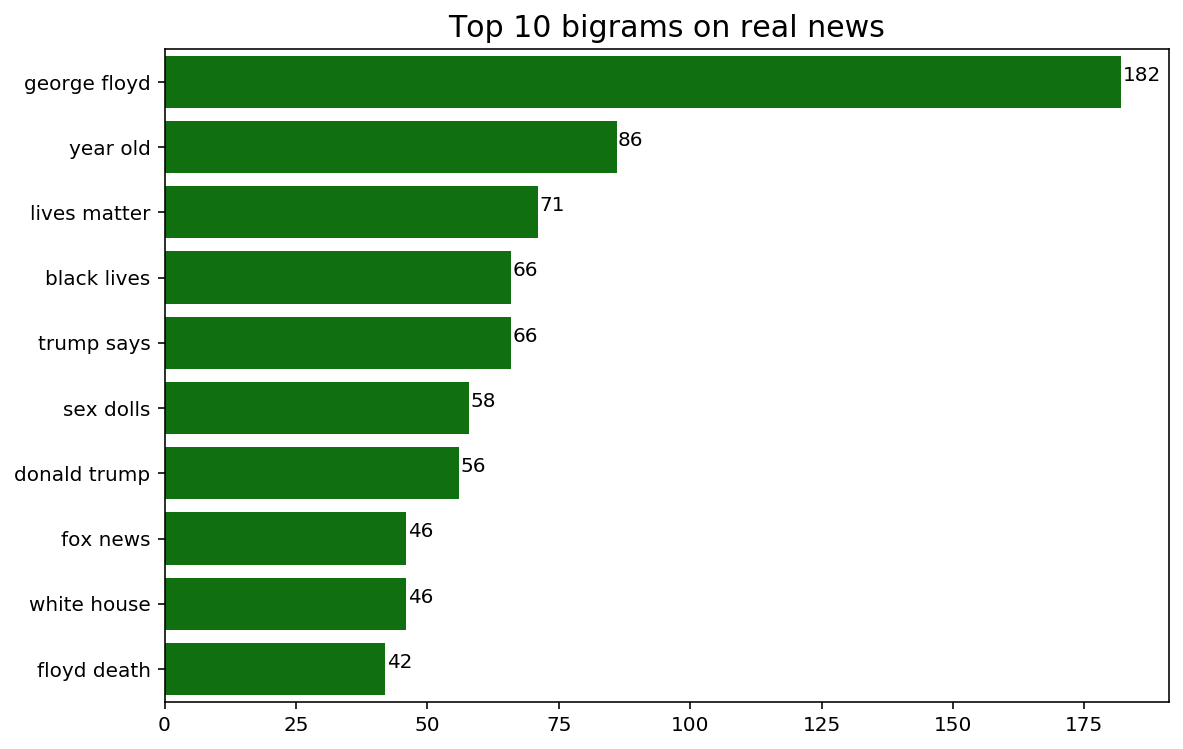

In [50]:
# Set up variables to contain top 10 most used bigrams
real_wc = real_cvec_df.sum(axis = 0)
real_top_10 = real_wc.sort_values(ascending=False).head(10)

# Call function
bar_plot(real_top_10.values, real_top_10.index, 'Top 10 bigrams on real news','g') 

create set to find common words between real and fake news

In [51]:
real_top_10_set = set(real_top_10.index)
fake_top_10_set = set(fake_top_10.index)

# Return common words
common_bigrams = fake_top_10_set.intersection(real_top_10_set)
common_bigrams

set()

### Count Vectorize `df` where `Fake` is `1`
 - `ngram_range = (3,3)`

In [52]:
# Set variables to show fake Titles
mask = df['Fake'] == 1
df_Fake_titles = df[mask]['title']

# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english', ngram_range=(3,3))

# Fit and transform the vectorizer on our corpus
fake_cvec = cv.fit_transform(df_Fake_titles)

# Convert fake_cvec into a DataFrame
fake_cvec_df = pd.DataFrame(fake_cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect head of fake Titles cvec
print(fake_cvec_df.shape)

(10807, 62116)


### Count Vectorize `df` where `Fake` is `0`
 - `ngram_range = (3,3)`

In [53]:
# Set variables to show real Titles
mask = df['Fake'] == 0
df_real_titles = df[mask]['title']

# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english', ngram_range=(3,3))

# Fit and transform the vectorizer on our corpus
real_cvec = cv.fit_transform(df_real_titles)

# Convert real_cvec into a DataFrame
real_cvec_df = pd.DataFrame(real_cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect head of real Titles cvec
print(real_cvec_df.shape)

(5826, 31770)


### Fake: Top 10 Trigrams


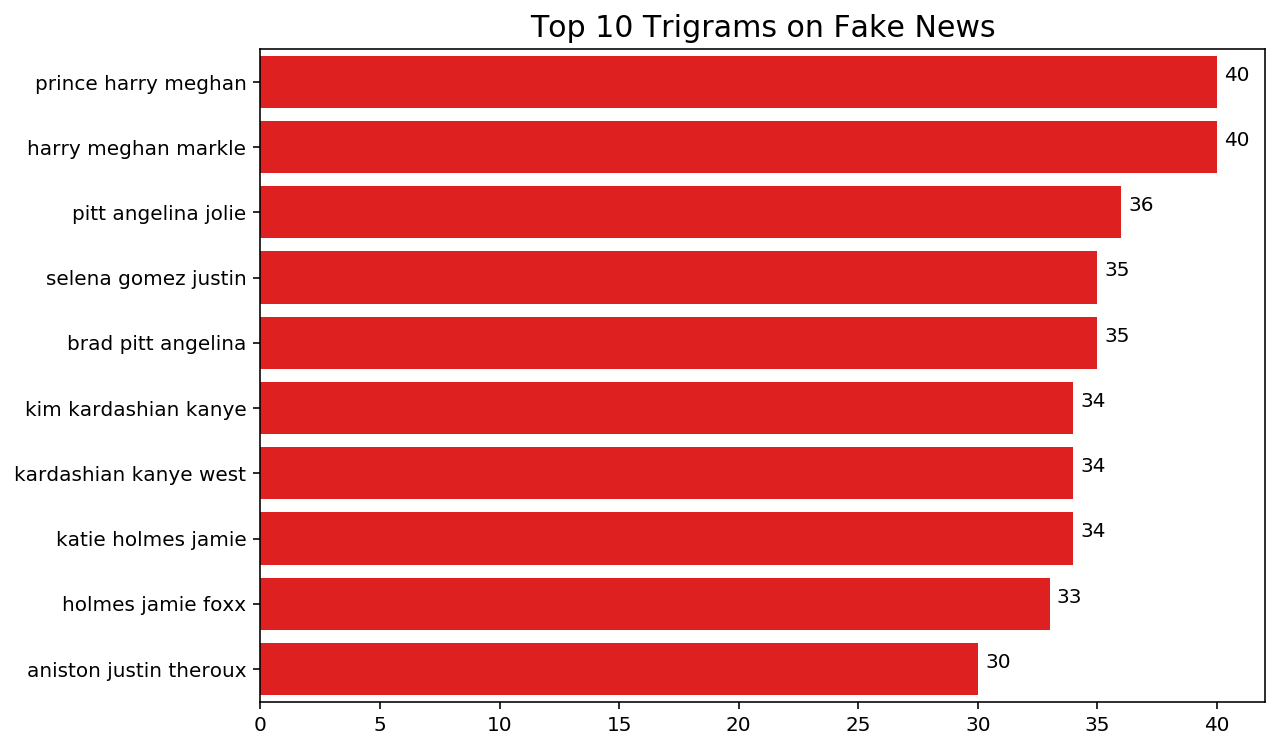

In [54]:
# Set up variables to contain top 10 most used trigrams 
fake_wc = fake_cvec_df.sum(axis = 0)
fake_top_10 = fake_wc.sort_values(ascending=False).head(10)

# Call function
bar_plot(fake_top_10.values, fake_top_10.index, 'Top 10 Trigrams on Fake News','r') 

### Real: Top 10 Trigrams


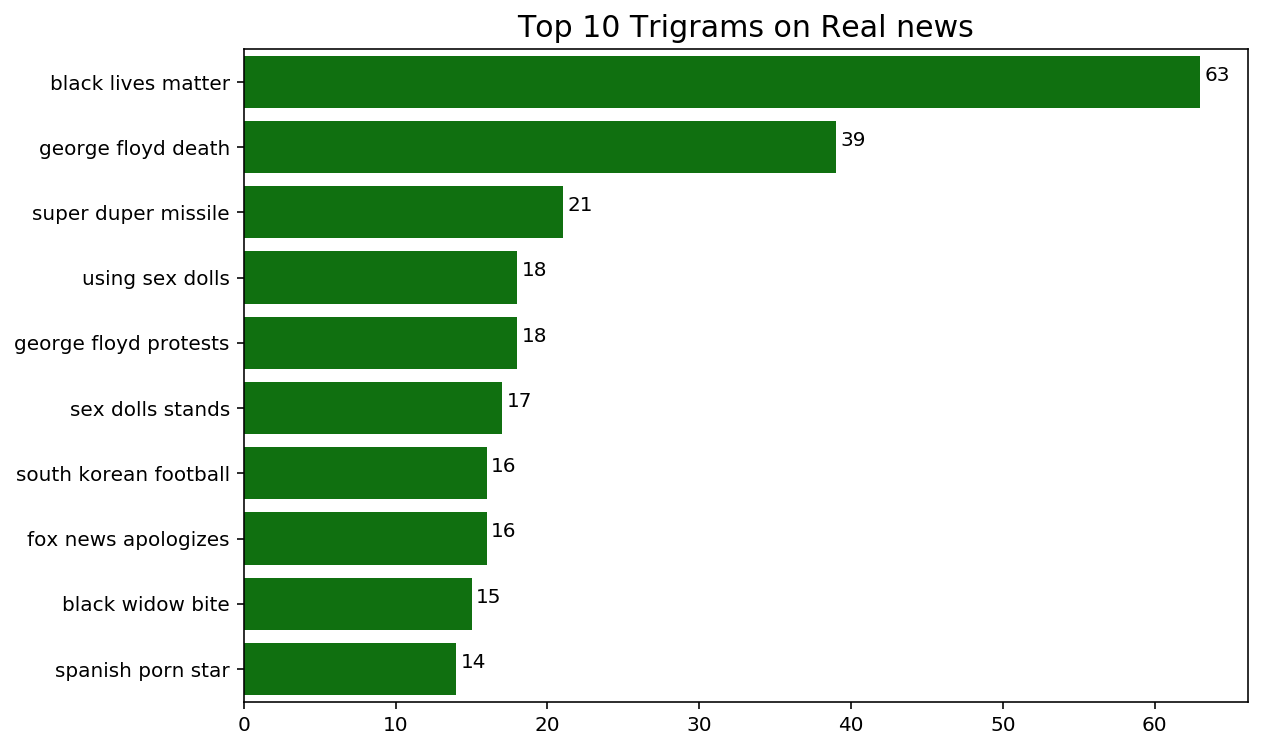

In [55]:
# Set up variables to contain top 10 most used trigrams 
real_wc = real_cvec_df.sum(axis = 0)
real_top_10 = real_wc.sort_values(ascending=False).head(10)

# Call function
bar_plot(real_top_10.values, real_top_10.index, 'Top 10 Trigrams on Real news','g') 

set to find the common words between real and fake

In [56]:
real_top_10_set = set(real_top_10.index)
fake_top_10_set = set(fake_top_10.index)

# Return common words
common_trigrams = fake_top_10_set.intersection(real_top_10_set)
common_trigrams

set()

Creating custom stop words including words from set of unigrams

In [57]:
# Create lists 
custom = stop_words.ENGLISH_STOP_WORDS
custom = list(custom)
common_unigrams = list(common_unigrams)
for i in common_unigrams:
    custom.append(i)

# Modeling

## Baseline Score

In [58]:
df['Fake'].value_counts(normalize=True)

1    0.649732
0    0.350268
Name: Fake, dtype: float64

## Test Train Split

In [59]:
X = df['title']
y = df['Fake']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y)

### Model 1:  Logistic Regression and CountVectorizer 

In [61]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Different Parameters to try
pipe_params = {'cvec__stop_words': [None, 'english', custom],
               'cvec__ngram_range': [(1,1), (2,2), (1,3)],
               'lr__C': [0.01, 1]}
# GridSearch to find best
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))
print("Best score:", gs.best_score_)
print("Best paramenters are :{}".format(gs.best_params_))


Train score 0.9964726631393298
Test score 0.877614811252705
Best score: 0.8589065255731922
Best paramenters are :{'cvec__ngram_range': (1, 3), 'cvec__stop_words': None, 'lr__C': 1}


### Model 2:  Logistic Regression and TfidfVectorize


In [62]:
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'tvect__stop_words': [None, 'english', custom],
                'tvect__max_df': [.75, .98, 1.0],
               'tvect__min_df': [2, 3, 5],
               'tvect__ngram_range': [(1,1), (1,2), (1,3)],
               'lr__C': [1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);

print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))
print("Best score:", gs.best_score_)
gs.best_params_

Train score 0.9248837582170916
Test score 0.8603029574416927
Best score: 0.8464005130671798


{'lr__C': 1,
 'tvect__max_df': 0.75,
 'tvect__min_df': 2,
 'tvect__ngram_range': (1, 2),
 'tvect__stop_words': None}

### Model 3:  MultinomialNB and CountVectorizer 

In [63]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'cvec__stop_words': [None, 'english', custom],
                'cvec__ngram_range': [(1,1),(1,3)],
               'nb__alpha': [.36, .6]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);

print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))
print("Best score:", gs.best_score_)
gs.best_params_

Train score 0.9951899951899952
Test score 0.8732868477999519
Best score: 0.867564534231201


{'cvec__ngram_range': (1, 3), 'cvec__stop_words': None, 'nb__alpha': 0.6}

### Model 4: MultinomialNB and TfidfVectorizer

In [64]:
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'tvect__stop_words': [None, 'english', custom],
                'tvect__max_df': [.75, .98],
               'tvect__min_df': [4, 5],
               'tvect__ngram_range': [(1,2), (1,3)],
               'nb__alpha': [0.1, 1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5)
gs.fit(X_train, y_train);

print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))
print("Best score:", gs.best_score_)
gs.best_params_

Train score 0.9211960878627545
Test score 0.8545323395046887
Best score: 0.8542566126639807


{'nb__alpha': 0.1,
 'tvect__max_df': 0.75,
 'tvect__min_df': 4,
 'tvect__ngram_range': (1, 2),
 'tvect__stop_words': None}

**Model Comparison**

Model 1:
Train score 0.9964726631393298
Test score 0.877614811252705
Best score: 0.8589065255731922

Model 2:
Train score 0.9248837582170916
Test score 0.8603029574416927
Best score: 0.8464005130671798

Model 3:
Train score 0.9951899951899952
Test score 0.8732868477999519
Best score: 0.867564534231201

Model 4:
Train score 0.9211960878627545
Test score 0.8545323395046887
Best score: 0.8542566126639807

Model 3 **(MultinomialNB and CountVectorizer)**
has the best accuracy of 86.7. So model will be trained like Model 3

In [65]:
stop_words_onion = stop_words.ENGLISH_STOP_WORDS
stop_words_onion = list(stop_words_onion)

### MultinomialNB and CountVectorizer

In [66]:
mnb=MultinomialNB(alpha=0.6)
cv=CountVectorizer(stop_words=stop_words_onion,ngram_range=(1,3))

In [67]:
cv.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 3), preprocessor=None,
                stop_words=['indeed', 'same', 'most', 'hereby', 'becoming',
                            'yourselves', 'go', 'and', 'along', 'only',
                            'otherwise', 'above', 'thence', 'whoever',
                            'somehow', 'will', 'too', 'been', 'but', 'six',
                            'five', 'or', 'for', 'call', 'towards', 'move',
                            'very', 'sometime', 'nobody', 'your', ...],
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [68]:
Xcv_train = cv.transform(X_train)
Xcv_test = cv.transform(X_test)

In [69]:
mnb.fit(Xcv_train,y_train)

MultinomialNB(alpha=0.6, class_prior=None, fit_prior=True)

In [70]:
mnb_preds = mnb.predict(Xcv_test)

In [71]:
print(mnb.score(Xcv_test, y_test))

0.8752103871122866


### Coefficient Analysis

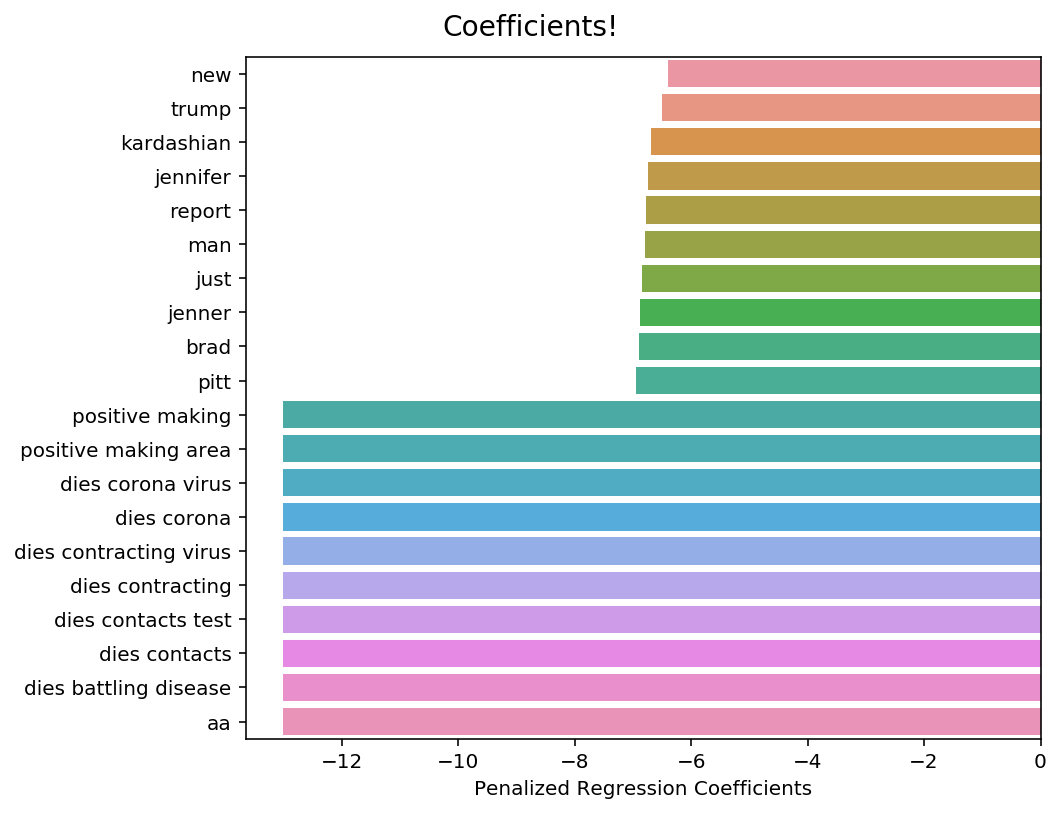

In [72]:
mnb_coef = np.array(mnb.coef_).tolist()
mnb_coef = mnb_coef[0]

# create dataframe from lasso coef
mnb_coef = pd.DataFrame(np.round_(mnb_coef, decimals=3), 
cv.get_feature_names(), columns = ["penalized_regression_coefficients"])

# sort the values from high to low
mnb_coef = mnb_coef.sort_values(by = 'penalized_regression_coefficients', ascending = False)
 
# create best and worst performing lasso coef dataframes
df_head = mnb_coef.head(10)
df_tail = mnb_coef.tail(10)

# merge back together
df_merged = pd.concat([df_head, df_tail], axis=0)

# plot the sorted dataframe
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
fig.suptitle('Coefficients!', size=14)
ax = sns.barplot(x = 'penalized_regression_coefficients', y= df_merged.index, data=df_merged)
ax.set(xlabel='Penalized Regression Coefficients')
plt.tight_layout(pad=3, w_pad=0, h_pad=0);

In [73]:
# Show coefficients that affect the news Being Fake News
df_merged_head = df_merged.head(10)
exp = df_merged_head['penalized_regression_coefficients'].apply(lambda x: np.exp(x))
df_merged_head.insert(1, 'exp', exp)
df_merged_head.sort_values('exp', ascending=False)

,penalized_regression_coefficients,exp
new,-6.402,0.001658
trump,-6.507,0.001493
kardashian,-6.698,0.001233
jennifer,-6.741,0.001181
report,-6.773,0.001144
man,-6.790,0.001125
just,-6.852,0.001057
jenner,-6.877,0.001031
brad,-6.903,0.001005
pitt,-6.941,0.000967


In [74]:
# Show coefficients that affect the news Being real
df_merged_tail = df_merged.tail(10)
exp = df_merged_tail['penalized_regression_coefficients'].apply(lambda x: np.exp(x * -1))
df_merged_tail.insert(1, 'exp', exp)
df_merged_tail.sort_values('exp', ascending=False)

,penalized_regression_coefficients,exp
positive making,-13.003,443742.625038
positive making area,-13.003,443742.625038
dies corona virus,-13.003,443742.625038
dies corona,-13.003,443742.625038
dies contracting virus,-13.003,443742.625038
dies contracting,-13.003,443742.625038
dies contacts test,-13.003,443742.625038
dies contacts,-13.003,443742.625038
dies battling disease,-13.003,443742.625038
aa,-13.003,443742.625038


## Confusion Matrix

In [75]:
cnf_matrix = metrics.confusion_matrix(y_test, mnb_preds)
cnf_matrix

array([[1187,  270],
       [ 249, 2453]])

Text(0.5, 257.44, 'Predicted label')

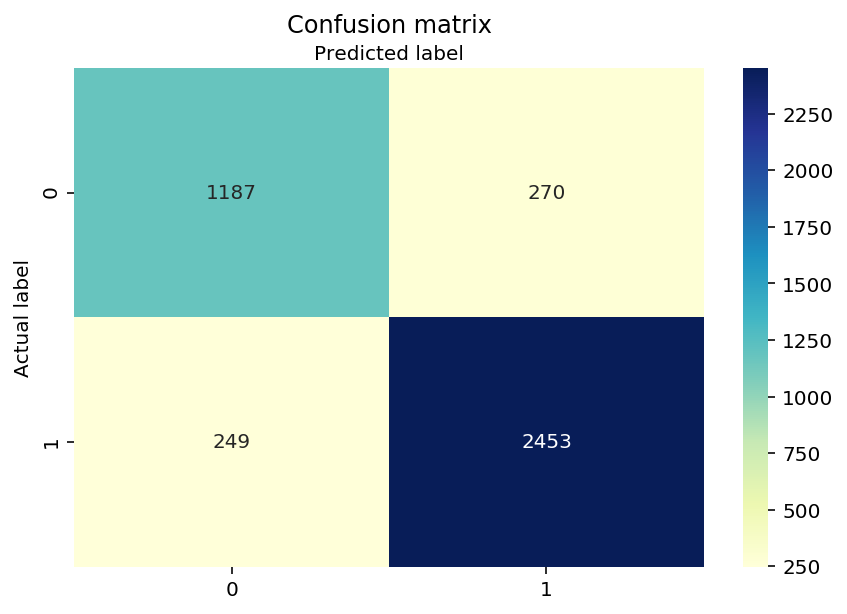

In [76]:
class_names=[0,1] 

# Set fig and axes 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [77]:
cnf_matrix = np.array(cnf_matrix).tolist()

tn_fp, fn_tp = cnf_matrix

tn, fp = tn_fp
fn, tp = fn_tp

In [78]:
print("Accuracy:",round(metrics.accuracy_score(y_test, mnb_preds)*100, 2),'%')
print("Precision:",round(metrics.precision_score(y_test, mnb_preds)*100, 2), '%')
print("Recall:",round(metrics.recall_score(y_test, mnb_preds)*100, 2), '%')
print("Specificity:", round((tn/(tn+fp))*100, 2), '%')
print("Misclassification Rate:", round((fp+fn)/(tn+fp+fn+tn)*100, 2), '%')

Accuracy: 87.52 %
Precision: 90.08 %
Recall: 90.78 %
Specificity: 81.47 %
Misclassification Rate: 17.94 %


Best model for this dataset is MultinomialNB and CountVectorizer with alpha=0.6 and ngram_range=(1,3)

Accuracy: 87.52 %
    Precision: 90.08 %
    Recall: 90.78 %
    Specificity: 81.47 %
    Misclassification Rate: 17.94 %